# Implementation of Theorem 1.2 (limitations via VC dimension)

This notebook builds a **small fixed neural network architecture** and tests its ability to fit **uniform random labels**
on an increasing number of data points.

**Theorem 1.2 (informal):** for a fixed semi-algebraic network class (ReLU networks) with fixed parameters/layers/nodes,
if you take enough points and assign **random labels**, then with high probability **no network in the class** can achieve
training error below **1/4**.

In practice, the theorem's bound on the required sample size `n` is huge,
but the qualitative behavior is easy to see:
- with a lot of **many randomly-labeled points** compared to the number of parameters, training error stays close to **1/2** (random guessing)
- and typically does **not** drop below **1/4** once `n` is large enough.

We will:
1. Choose a ReLU MLP architecture (fixed depth and width).
2. Compute the theorem's **n-threshold** using the paper's parameters for ReLU gates.
3. Empirically train the network on random labels for several `n` and measure the best training error reached.


In [1]:
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 1) Pick a fixed architecture and compute the Theorem 1.2 bound

In Telgarsky (2016), standard ReLU gates are **(t, α, β)-semi-algebraic** with:
- `t = 1`, `α = 1`, `β = 1` (see Lemma 2.3 in the paper).

Theorem 1.2 uses:
- `p` = number of **free parameters**
- `l` = number of **layers** (excluding the input layer, per the paper's convention)
- `m` = number of **nodes** (total computational nodes, roughly all hidden + output units)

Bound computed :

`n >= 8 * p * l^2 * ln( 8 e m t α β p (l+1) ) + 4 ln(1/δ)`  ⇒ with probability ≥ 1-δ over random labels,  
the best achievable training error is at least 1/4.

We'll compute this bound for our chosen architecture.


In [ ]:
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def build_mlp(d_in: int, hidden_width: int, n_hidden_layers: int) -> nn.Module:
    layers = []
    d = d_in
    for _ in range(n_hidden_layers):
        layers.append(nn.Linear(d, hidden_width))
        layers.append(nn.ReLU())
        d = hidden_width
    layers.append(nn.Linear(d, 1))
    return nn.Sequential(*layers)

d_in = 20
hidden_width = 3
n_hidden_layers = 2 
model = build_mlp(d_in, hidden_width, n_hidden_layers).to(device)

p = count_parameters(model)
l = n_hidden_layers + 1 
m = n_hidden_layers * hidden_width + 

# ReLU is (1, 1, 1)-sa
t_sa, alpha_sa, beta_sa = 1, 1, 1

delta = 0.05
n_bound = int(math.ceil(
    8 * p * (l**2) * math.log(8 * math.e * m * t_sa * alpha_sa * beta_sa * p * (l + 1))
    + 4 * math.log(1/delta)
))

p, l, m, n_bound


(79, 3, 7, 61335)

**Interpretation:** the theoretical threshold `n_bound` is extremely large as expected.
So we **do not expect** to reach that `n` in this demo.  

we will:
- sweep moderate values of `n` (e.g., 100 → 10000),
- run multiple random restarts / trials,
- report the **best** training error achieved.


## 2) Experiment: fit random labels and measure best training error

Setup:
- Inputs `x_i` sampled iid from a standard normal in R^d.
- Labels `y_i` sampled iid uniformly from {0,1}.
- Train the fixed network with Adam on BCEWithLogitsLoss.
- Track the **best training error** during training.
- Repeat for multiple seeds and keep statistics.


Utils :

In [3]:
def make_random_dataset(n: int, d: int, seed: int):
    g = torch.Generator(device="cpu").manual_seed(seed)
    x = torch.randn(n, d, generator=g)
    y = torch.randint(0, 2, (n, 1), generator=g).float()
    return x.to(device), y.to(device)

@torch.no_grad()
def classification_error(model: nn.Module, x: torch.Tensor, y: torch.Tensor) -> float:
    model.eval()
    logits = model(x)
    pred = (torch.sigmoid(logits) >= 0.5).float()
    return (pred != y).float().mean().item()

## 3) Sweep over n and plot error vs n

We run multiple trials per `n` and collect:
- mean best error
- min best error across trials (optimistic)
- standard deviation

We also plot a horizontal line at **0.25** (the threshold in Theorem 1.2).


In [4]:
def train(
    n: int,
    d: int,
    hidden_width: int,
    n_hidden_layers: int,
    seed: int,
    epochs: int = 30,
    batch_size: int = 128,
    lr: float = 2e-3,
    weight_decay: float = 0.0,
    eval_every: int = 1,
    show_pbar: bool = True,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    x, y = make_random_dataset(n, d, seed=seed)
    dataset = TensorDataset(x, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = build_mlp(d, hidden_width, n_hidden_layers).to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()

    best_err = 1.0
    best_epoch = 0

    loss_history = []
    err_history = []

    epoch_iter = range(1, epochs + 1)

    for epoch in epoch_iter:
        model.train()
        running_loss = 0.0
        n_seen = 0

        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

            bs = xb.size(0)
            running_loss += loss.item() * bs
            n_seen += bs

        avg_loss = running_loss / max(1, n_seen)
        loss_history.append(avg_loss)

        if epoch % eval_every == 0:
            err = classification_error(model, x, y)
            err_history.append(err)
            if err < best_err:
                best_err = err
                best_epoch = epoch

            if show_pbar:
                epoch_iter.set_postfix(loss=avg_loss, err=err, best=best_err)

    return best_err, best_epoch, loss_history, err_history


In [ ]:
n_values = [100, 200, 800, 1600, 4000, 10000]
trials_per_n = 5

epochs = 130
batch_size = 128
lr = 2e-3

results = []
curves = {}

t0 = time.time()

for n in n_values:
    errs = []
    best_epochs = []

    best_trial_err = 1.0
    best_trial_loss = None
    best_trial_err_hist = None
    best_trial_epoch = None

    for t in range(trials_per_n):
        seed = 1000 * n + t

        best_err, best_epoch, loss_hist, err_hist = train(
            n=n,
            d=d_in,
            hidden_width=hidden_width,
            n_hidden_layers=n_hidden_layers,
            seed=seed,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            show_pbar=False,
        )

        errs.append(best_err)
        best_epochs.append(best_epoch)

        if best_err < best_trial_err:
            best_trial_err = best_err
            best_trial_loss = loss_hist
            best_trial_err_hist = err_hist
            best_trial_epoch = best_epoch

    results.append({
        "n": n,
        "best_err_mean": float(np.mean(errs)),
        "best_err_std": float(np.std(errs)),
        "best_err_min": float(np.min(errs)),
        "best_err_max": float(np.max(errs)),
        "best_epoch_mean": float(np.mean(best_epochs)),
        "errs": errs,
    })

    curves[n] = {
        "loss": best_trial_loss,
        "err": best_trial_err_hist,
        "best_err": best_trial_err,
        "best_epoch": best_trial_epoch,
    }

    print(f"n={n:5d} | best_err mean={np.mean(errs):.3f} std={np.std(errs):.3f} min={np.min(errs):.3f}")

print(f"Total time: {time.time()-t0:.1f}s")
results[:2]


n=  100 | best_err mean=0.286 std=0.086 min=0.190
n=  200 | best_err mean=0.402 std=0.104 min=0.250
n=  800 | best_err mean=0.373 std=0.020 min=0.347
n= 1600 | best_err mean=0.403 std=0.018 min=0.379


NOTE : we ran that code in GOOGLE COLAB using GPU T4 and tried with more iterations so those results are not the one in the folder results. We still can see that the classification error test increases with the number of label.

RESULTS with more GPU ressources at ./Limitation_of_depth

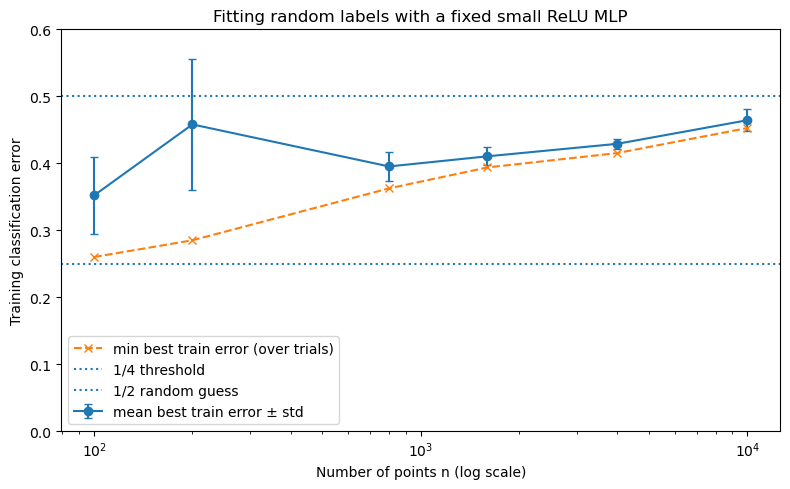

In [7]:
def plot_classification_error(ns, mean_err,std_err,min_err):
    plt.figure(figsize=(8,5))
    plt.errorbar(ns, mean_err, yerr=std_err, marker="o", capsize=3, label="mean best train error ± std")
    plt.plot(ns, min_err, marker="x", linestyle="--", label="min best train error (over trials)")
    plt.axhline(0.25, linestyle=":", label="1/4 threshold")
    plt.axhline(0.5, linestyle=":", label="1/2 random guess")
    plt.xscale("log")
    plt.ylim(0.0, 0.6)
    plt.xlabel("Number of points n (log scale)")
    plt.ylabel("Training classification error")
    plt.title("Fitting random labels with a fixed small ReLU MLP")
    plt.legend()
    plt.tight_layout()
    plt.show()


ns = np.array([r["n"] for r in results])
mean_err = np.array([r["best_err_mean"] for r in results])
std_err  = np.array([r["best_err_std"] for r in results])
min_err  = np.array([r["best_err_min"] for r in results])
plot_classification_error(ns, mean_err,std_err,min_err)


We check here if the training loss converged :

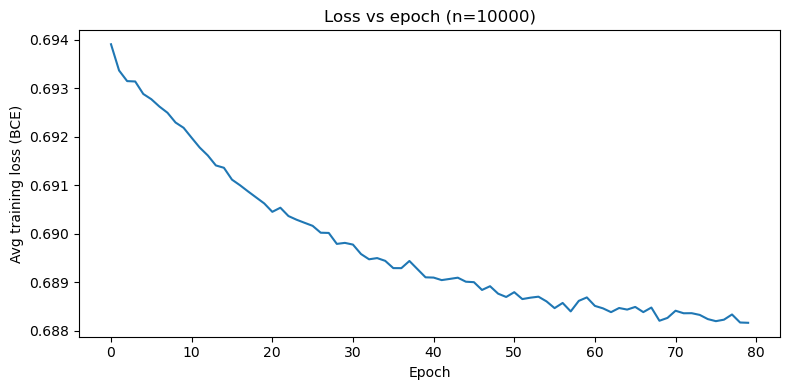

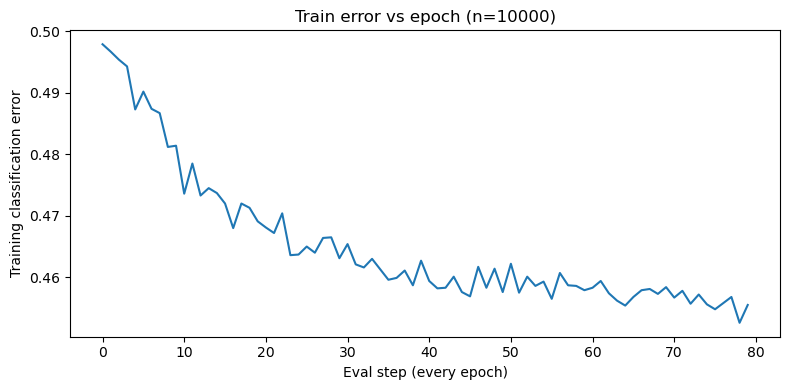

In [ ]:
n = 10000
loss_hist = curves[n]["loss"]
err_hist  = curves[n]["err"]

def plot_training_loss(n, loss_hist, err_hist):
    plt.figure(figsize=(8,4))
    plt.plot(loss_hist)
    plt.xlabel("Epoch")
    plt.ylabel("Avg training loss (BCE)")
    plt.title(f"Loss vs epoch (n={n})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(err_hist)
    plt.xlabel("Eval step (every epoch)")
    plt.ylabel("Training classification error")
    plt.title(f"Train error vs epoch (n={n})")
    plt.tight_layout()
    plt.show()

plot_training_loss(n, loss_hist, err_hist)